### In this notebook, we work with masked data and VGG16 CNN architecture.

#### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

#### Load Data

In [3]:
train_masked_df = pd.read_csv('../src/data/split_data/train_balanced_masked.csv')
print(f'The shape of the dataframe: {train_masked_df.shape}')
train_masked_df.head()

The shape of the dataframe: (14984, 2)


,Label,Image_Path
0,basophil,../src/data/split_data/train_balanced_masked/b...
1,basophil,../src/data/split_data/train_balanced_masked/b...
2,basophil,../src/data/split_data/train_balanced_masked/b...
3,basophil,../src/data/split_data/train_balanced_masked/b...
4,basophil,../src/data/split_data/train_balanced_masked/b...


In [4]:
val_df = pd.read_csv('../src/data/split_data/val_masked.csv')
print(f'The shape of the dataframe: {val_df.shape}')
val_df.head()

The shape of the dataframe: (3164, 2)


,Label,Image_Path
0,basophil,../src/data/split_data/val_masked/basophil/pro...
1,basophil,../src/data/split_data/val_masked/basophil/pro...
2,basophil,../src/data/split_data/val_masked/basophil/pro...
3,basophil,../src/data/split_data/val_masked/basophil/pro...
4,basophil,../src/data/split_data/val_masked/basophil/pro...


In [5]:
test_df = pd.read_csv('../src/data/split_data/test_masked.csv')
print(f'The shape of the dataframe: {test_df.shape}')
test_df.head()

The shape of the dataframe: (3164, 2)


,Label,Image_Path
0,basophil,../src/data/split_data/test_masked/basophil/pr...
1,basophil,../src/data/split_data/test_masked/basophil/pr...
2,basophil,../src/data/split_data/test_masked/basophil/pr...
3,basophil,../src/data/split_data/test_masked/basophil/pr...
4,basophil,../src/data/split_data/test_masked/basophil/pr...


#### Define ImageDataGenerators for training, validation, and testing with rescaling


In [6]:
train_val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators
train_generator = train_val_test_datagen.flow_from_dataframe(
    train_masked_df,
    x_col='Image_Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = train_val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='Image_Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = train_val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='Image_Path',
    y_col='Label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14984 validated image filenames belonging to 8 classes.
Found 3164 validated image filenames belonging to 8 classes.
Found 3164 validated image filenames belonging to 8 classes.


#### Build Model

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

2024-06-17 16:48:39.167983: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-17 16:48:39.168004: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-17 16:48:39.168011: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-17 16:48:39.168074: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-17 16:48:39.168320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Add custom layers on top of the VGG16 base


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)  # 8 classes for the classifier

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Define the path to save the best model and training log
best_model_path = '../src/data/best_model_masked.h5'
training_log_path = '../src/data/training_log_masked.csv'


# Define callbacks
callbacks = [
    ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min'),
    CSVLogger(training_log_path)
]


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20
)

Epoch 1/20


2024-06-17 16:48:39.963859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - ETA: 0s - loss: 1.5474 - accuracy: 0.5066

2024-06-17 16:50:03.895322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


468/468 [==============================] - 102s 216ms/step - loss: 1.5474 - accuracy: 0.5066 - val_loss: 1.0312 - val_accuracy: 0.7589
Epoch 2/20
468/468 [==============================] - 101s 216ms/step - loss: 0.9197 - accuracy: 0.7652 - val_loss: 0.6991 - val_accuracy: 0.8409
Epoch 3/20
468/468 [==============================] - 101s 216ms/step - loss: 0.6869 - accuracy: 0.8119 - val_loss: 0.5802 - val_accuracy: 0.8450
Epoch 4/20
468/468 [==============================] - 101s 216ms/step - loss: 0.5653 - accuracy: 0.8358 - val_loss: 0.4884 - val_accuracy: 0.8622
Epoch 5/20
468/468 [==============================] - 101s 216ms/step - loss: 0.4883 - accuracy: 0.8560 - val_loss: 0.4172 - val_accuracy: 0.8811
Epoch 6/20
468/468 [==============================] - 101s 216ms/step - loss: 0.4332 - accuracy: 0.8708 - val_loss: 0.3908 - val_accuracy: 0.8849
Epoch 7/20
468/468 [==============================] - 101s 216ms/step - loss: 0.3935 - accuracy: 0.8818 - val_loss: 0.3567 - val_accura

#### Evaluate Model Performance

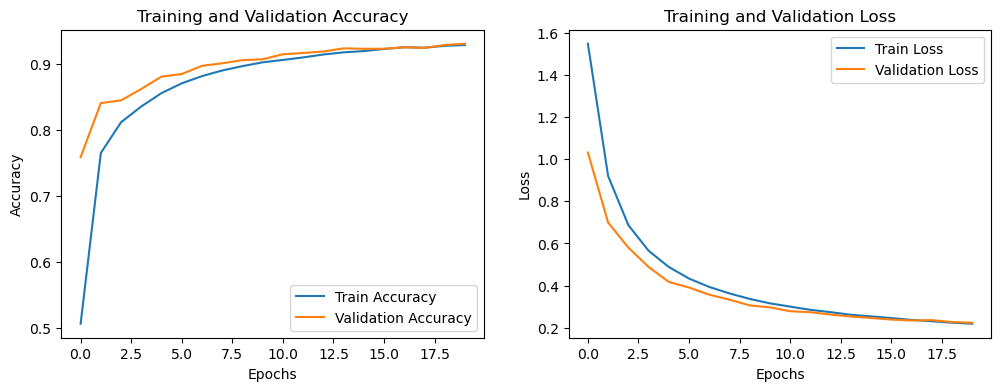

In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot training history
plot_training_history(history)


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


99/99 [==============================] - 18s 179ms/step - loss: 0.2091 - accuracy: 0.9320
Test Loss: 0.20913881063461304
Test Accuracy: 0.9320480227470398


 1/99 [..............................] - ETA: 13s

2024-06-17 17:22:41.768092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 18s 181ms/step


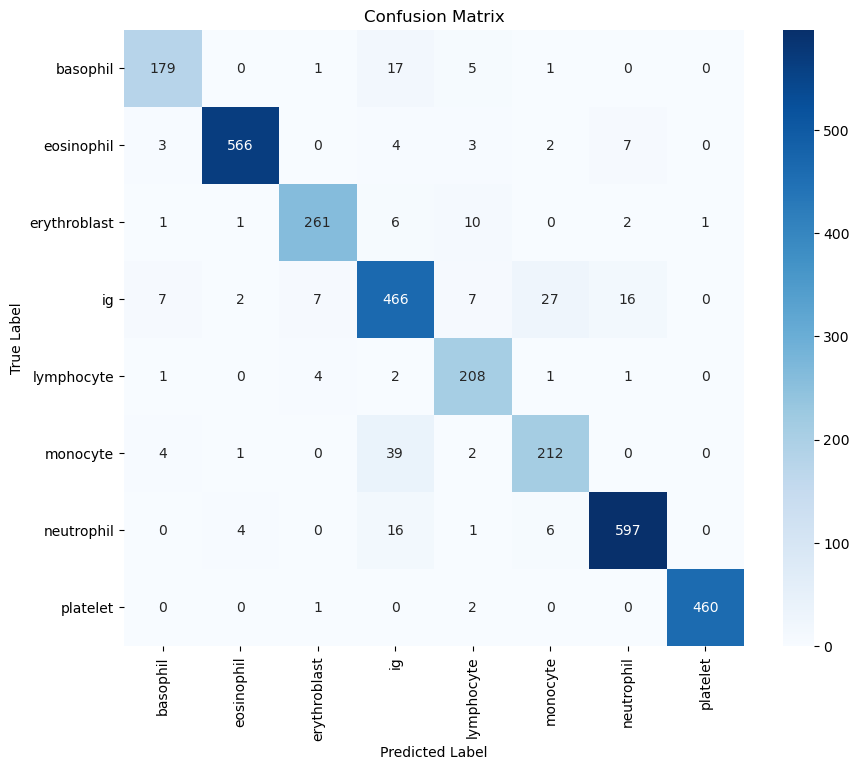

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Classification report
class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(class_report)


              precision    recall  f1-score   support

    basophil       0.92      0.88      0.90       203
  eosinophil       0.99      0.97      0.98       585
erythroblast       0.95      0.93      0.94       282
          ig       0.85      0.88      0.86       532
  lymphocyte       0.87      0.96      0.91       217
    monocyte       0.85      0.82      0.84       258
  neutrophil       0.96      0.96      0.96       624
    platelet       1.00      0.99      1.00       463

    accuracy                           0.93      3164
   macro avg       0.92      0.92      0.92      3164
weighted avg       0.93      0.93      0.93      3164



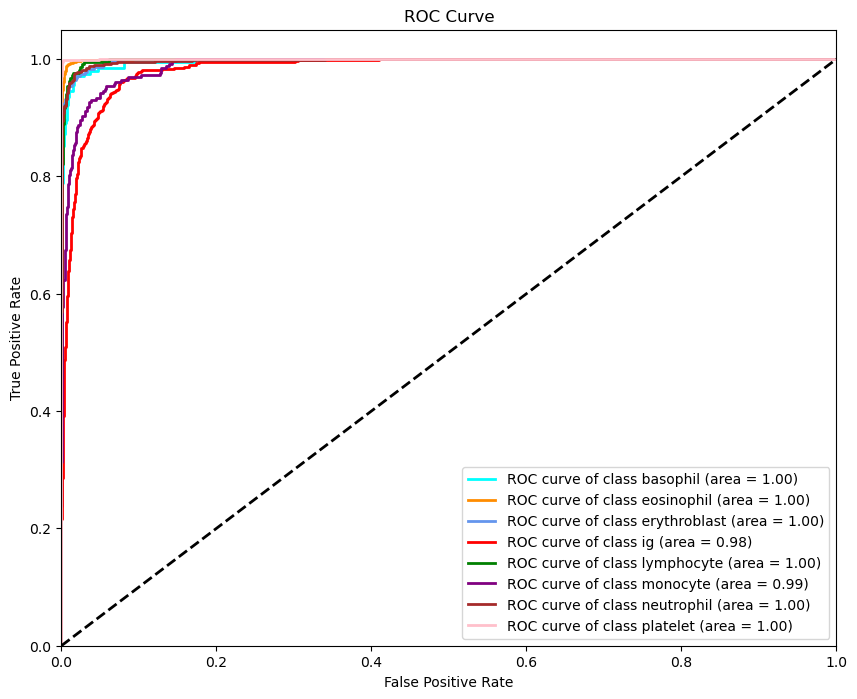

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output
y_true_bin = label_binarize(y_true, classes=[*range(len(test_generator.class_indices))])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {list(test_generator.class_indices.keys())[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [18]:
# Save the final model
final_model_path = '../src/data/final_model_masked_20epoch_VGG16.h5'
model.save(final_model_path)
print(f'Model saved to {final_model_path}')

# Load the model
from tensorflow.keras.models import load_model

loaded_model = load_model(final_model_path)
print('Model loaded successfully')

# Predict using the loaded model
loaded_model_predictions = loaded_model.predict(test_generator)


/Users/mahdihabibi/anaconda3/envs/bloodCNN/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to ../src/data/final_model_masked_20epoch_VGG16.h5
Model loaded successfully
 1/99 [..............................] - ETA: 11s

2024-06-17 17:23:00.319599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 18s 182ms/step
